# Recommendation Engine - Philadelphia Neighborhoods for NYC Commuters
## Prepared as the capstone project for Courseara Applied Data Science

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)


## Introduction Section : Business Problem <a name="introduction"></a>
The New York City real estate is one of the most expensive real estate markets in the U.S. and around the globe. Due to the high costs of living, many people that work in NYC would prefer to commute and own a home outside of the city. However, these same people also want the benefits that come along with big city life. 

Philadelphia has much of the same benefits of NYC with a diverse community, major league sports, large population, similar climate, large cultural events and locations, and a signficant number of highly-rated restaurants and other establishments. In addition, commuters can get trains directly from Philadelphia to downtown NYC in about an hour to an hour and half. Yet, property prices in Philadelphia per square foot are significantly lower than those in NYC (by a factor of 4).

Therefore, over the past several years, Philadelphia has seen an influx of people from NYC. Especially people with families that are not looking to spend their entire salary on a small place in the city and want some of the amenities that big cities have to offer. 

**Problem Statement :** How does someone from NYC know which neighborhoods are similar to the ones they like in NYC? By creating a clustering model of both NYC and Philly neighborhoods, we should be able to provide them with like neighborhoods. This should help to narrow or simplify their search for a place in Philadelphia that is similar to those they know in NYC in terms of demographics and the variety and quantify of establishments within major categories like restaurants, bars, religious, financials, and others. 


* * *

## Data Section: <a name="data"></a>
### The data required to create this analysis is drawn from the following sources:

1. Opendatasoft API : provides the list of neighborhoods, geographic coordinates, and demographic data from Zillow
2. Google Maps API : provides postal codes for the neighborhoods based on the latitude and longitude
3. Foursquare API : provides the venue data based on latitudes and longitudes of each neighborhood

The data is brought into 3 separate DataFrames, transformed, and linked and then combined at various steps in the analysis by neighborhood. The DataFrames are listed below:

1. Neighborhoods : Contains a list of the neighboorhoods for both cities with latitude, longitude, and postal code
2. Demographics : Contains the list of neighborhoods with Median Age, Income per Household, and racial diversity data
3. Places : Contains a list the neighborhoods and the places, categories, major categories, and quantity 

The common key to all of the tables is the name of the neighborhood which links the tables together


***

### Functions for retrieving the daat to create the 3 DataFrames

In [1224]:
# Function uses opendatasoft platform for to gather the geocoordinates for city neighborhoods
def get_neighborhoods (city, state, default_coords):

    # importing required modules 
    import requests, json
    import pandas as pd
    import numpy as np
    
    #define blank dataframe
    neighborhood_data = pd.DataFrame(columns=['Neighborhood','city','county','state','latitude','longitude'])

    url = 'https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods@public/download/?format=json&refine.\
           state={}&refine.city={}&timezone=America/New_York'.format(state, city)
    response = requests.get(url).json()
    
    #parse the json response and extract the data
    for id in range(len(response)): 
        name = response[id]['fields']['name']
        city = response[id]['fields']['city']
        county = response[id]['fields']['county']
        state = response[id]['fields']['state']
        coords = response[id]['fields'].get(['geo_point_2d'][0],default_coords)#.get method provides a default value when the field is missing
        lat = coords[0] 
        long = coords[1]
    
        #append each neighborhood to the dataframe
        neighborhood_data = neighborhood_data.append({'Neighborhood': name,
                                                      'city': city,
                                                      'county': county,
                                                      'state': state,
                                                      'latitude': lat,
                                                      'longitude': long}, ignore_index=True)
    #return dataframe object
    return (neighborhood_data)
        

In [1225]:
#Function uses Google maps geocoding API to retrive postal codes for each neighborhood
def get_postal_codes (latitude, longitude):
    
    #Google API credentials
    gapi_key = 'put your key here'  
    
    # importing required modules 
    import requests, json
    import pandas as pd
    import numpy as np
    
    postal_code_list = []
    
    for ind in range(len(latitude)):
        lat = latitude[ind]
        long = longitude[ind]
              
        # do a reverse lookup to get a postal code for each neighborhood
        url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={},{}&key={}'.format(lat, long, gapi_key)
        response = requests.get(url).json()
       
        # cycle through the Google response to find the postal code
        found=False
        for types in response['results'][0]['address_components']: 
            if types['types'] == ['postal_code']:
                postal_code_list.append(types['short_name'])
                found=True
        if not found: postal_code_list.append(0)    
    return (postal_code_list)

In [1226]:
#Function uses Forusquare API to retrive a list of places for each neighborhood
def get_places (neighborhoods, latitudes, longitudes, radius=500, LIMIT=100):
    
    
    # importing required modules 
    import requests, json
    import pandas as pd
    import numpy as np
    
    #Foursquare API credentials
    CLIENT_ID = 'your Fourquare id' # your Foursquare ID
    CLIENT_SECRET = 'your Foursquare secret' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    venues_list=[]
    
    for hood, lat, lng in zip (neighborhoods, latitudes, longitudes):
        
        #create the url to use to call Foursquare
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #send the request to Foursquare to get the data
        venues_data = requests.get(url).json()['response']['groups'][0]['items']
       
        if venues_data != []:
            #iterate through the json response to extract the data into a list
            for place in venues_data:
                venues_list.append([(
                    hood,
                    lat,
                    lng,
                    place['venue']['name'],
                    place['venue']['location']['lat'],
                    place['venue']['location']['lng'],
                    place['venue']['categories'][0]['name'])])
           
            #convert the list to a dataframe     
            venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            venues_df.columns = ['Neighborhood',
                                 'Neighborhood Latitude',
                                 'Neighborhood Longitude',
                                 'Venue',
                                 'Venue Latitude',
                                 'Venue Longitude',
                                 'Venue Category']
    
    return(venues_df)

### Retrieve the neighborhoods and their latitudes and longitudes

In [1231]:
# retrieve the NYC neighborhoods
neighborhoods = get_neighborhoods ('New York','NY',[40.7128, -74.0060])
print ("Found {} neighborhoods in NYC".format(len(neighborhoods)))

#retrieve the Phaildelphia neighborhoods
neighborhoods2 = get_neighborhoods ('Philadelphia','PA',[39.9526, -75.1652])
print ("Found {} neighborhoods in Philadelphia".format(len(neighborhoods2)))

#Remove duplicate rows where a neighborhood crosses into two counties. 
duplicate_rows = neighborhoods[neighborhoods.duplicated(['Neighborhood','latitude','longitude'])]

for row in duplicate_rows.index:
    neighborhoods.drop([row], axis=0, inplace=True)

print ('Removed {} duplicate rows from neighborhoods'.format(len(duplicate_rows)))

neighborhoods = neighborhoods.append(neighborhoods2)
print ('There are a total of {} neighborhoods in the DataFrame'.format(len(neighborhoods)))

Found 278 neighborhoods in NYC
Found 158 neighborhoods in Philadelphia
Removed 4 duplicate rows from neighborhoods
There are a total of 432 neighborhoods in the DataFrame


### Retrieve the postal codes for the neighborhoods and append to the neighborhoods dataframe

In [1232]:
#Retrieve the postal codes for the neighborhoods and append to the dataframe
p_codes = (get_postal_codes (neighborhoods['latitude'].tolist(),neighborhoods['longitude'].tolist()))
neighborhoods['postal_code']=p_codes

#convert postal codes to integer
neighborhoods['postal_code']=neighborhoods['postal_code'].astype('int64')

print('Added {} postal codes to the neighborhoods DataFrame'.format(len(neighborhoods['postal_code'])))
neighborhoods.head()

Added 432 postal codes to the neighborhoods DataFrame


,Neighborhood,city,county,state,latitude,longitude,postal_code
0,Fresh Kills,New York,Richmond,NY,40.569236,-74.201294,10312
1,Park Hill,New York,Richmond,NY,40.611493,-74.082984,10304
2,Kew Gardens Hills,New York,Queens,NY,40.730735,-73.822544,11367
3,Bloomfield,New York,Richmond,NY,40.615872,-74.187353,10314
4,Ellis Island,New York,New York,NY,40.699685,-74.039385,10280


### Retrieve Places from Foursquare and store in dataframe

In [1251]:
places = get_places(neighborhoods=neighborhoods['Neighborhood'],
                             latitudes=neighborhoods['latitude'],
                             longitudes=neighborhoods['longitude'])

#create major categories from the Foursquare categories
major_cats = pd.read_csv('/users/kellyjustice/Desktop/venues_categories.csv')
places = pd.merge(places, major_cats, left_on='Venue Category', right_on='category')
places = places.drop(columns=['category'], axis=1)

print('Added {} venues to the places DataFrame'.format(len(places)))
places.head()

Added 10777 venues to the places DataFrame


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,major
0,Park Hill,40.611493,-74.082984,El Pollo Restaurant,40.612991,-74.087308,Spanish Restaurant,restaurant
1,Belmont,40.858445,-73.885763,House of Antojitos,40.856001,-73.888063,Spanish Restaurant,restaurant
2,Hamilton Heights,40.826098,-73.950483,Sofrito,40.827349,-73.955200,Spanish Restaurant,restaurant
3,Harlem,40.813426,-73.944620,Tropical Grill & Restaurant,40.810583,-73.947170,Spanish Restaurant,restaurant
4,Washington Heights,40.848065,-73.936333,Mambi Steak House Bar & Grill,40.847615,-73.938143,Spanish Restaurant,restaurant


### Retrieve data from OpenDataSoft and store in demographcis dataframe

In [1410]:
#This section adds the demographics data to the existing dataframe
#import demographics data for the zipcodes from opendatasoft (file was downloaded due to time constraints from API)
demographics = pd.read_csv('/users/kellyjustice/Downloads/neighborhoods_updated.csv',
                           usecols=['Your Entry','ACS Age Median','ACS Household Income Median',
                                     'ACS Household Size Average','ACS Housing Value Median','ACS Race Asian',
                                     'ACS Race Black','ACS Race Hawaiian','ACS Race Indian','ACS Race Other',
                                     'ACS Race White','ACS Population'])

demographics.rename(columns={'Your Entry':'postal_code','ACS Age Median':'Median Age','ACS Household Income Median':'Median Household Income',
                             'ACS Household Size Average':'Avg Household Size','ACS Housing Value Median':'Median House Value',
                             'ACS Race Asian' : '% Asian','ACS Race Black' : '% African American','ACS Race Hawaiian':'% Hawaiian',
                             'ACS Race Indian':'% American Indian','ACS Race Other': '% Other','ACS Race White':'% White',
                             'ACS Population':'Population'}, inplace=True)

#convert race numbers to percentages of population
pop_columns = ['% Asian','% African American','% American Indian','% Hawaiian','% White','% Other']
for column in pop_columns:
    demographics[column]=(demographics[column]/demographics['Population'])    

#drop duplicate rows in the demographics table 
demographics.drop_duplicates(subset=None, keep='first', inplace=True)

#merge neighborhood into demographics dataframe
demographics = pd.merge(demographics, neighborhoods[['Neighborhood','postal_code']], on='postal_code', how='inner').reset_index(drop=True)

demographics = demographics[['Neighborhood','postal_code','Median Age','Median Household Income','Avg Household Size',
                             'Median House Value','Population','% Asian','% African American','% Hawaiian',
                             '% American Indian','% Other','% White']]

print('Demographic data for {} neighborhoods have been added to the DataFrame'.format(len(demographics)))
demographics.head()


Demographic data for 431 neighborhoods have been added to the DataFrame


,Neighborhood,postal_code,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,% Hawaiian,% American Indian,% Other,% White
0,Fairmount,19130,32.9,82632,2.00,371300,27410,0.073294,0.185918,0.0,0.002225,0.021416,0.685297
1,Spring Garden,19130,32.9,82632,2.00,371300,27410,0.073294,0.185918,0.0,0.002225,0.021416,0.685297
2,Francisville,19130,32.9,82632,2.00,371300,27410,0.073294,0.185918,0.0,0.002225,0.021416,0.685297
3,Fishtown,19125,33.0,65218,2.42,223800,24674,0.065129,0.045838,0.0,0.003161,0.054349,0.802910
4,East Kensington,19125,33.0,65218,2.42,223800,24674,0.065129,0.045838,0.0,0.003161,0.054349,0.802910


# Methodology & Analysis Section <a name="methodology"></a>

The neighborhoods recommendation engine uses a k means clustering model to find similar neighborhoods based upon various demographic and venue data. 

The first step was to connect to external APIs to get a list of neighborhoods in the 2 cities under review (New York and Philadelphia) including a list of latitudes and longitudes so that we could map the neighborhoods and determine a list of places/venues within a walking distance of the neighborhood center. The venue data was summarized by neighborhood to get counts (totals) for each major category of venue. 

The second step was to connect the postal codes tied to the neighborhoods so that we could create a link to demographic data as this data was only available at the postal code level. Demographic data include income, household, and racial diversity data. 

The data was collected through various APIs (listed in the Data section) and loaded into 3 separate data frames for review. 

Finally, the data was consolidated into a final table and transformed to normalize the values for processing by the kmeans clustering model. 

***

### Transform the places dataframe for reporting of top neighborhood venues

In [1712]:
#Convert categorical variables in venue category into dummy/indicator variables.
places_summary = pd.get_dummies(places['major'], prefix="", prefix_sep="")

# add 'Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude' columns back to dataframe 
key_columns =  ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']
places_summary[key_columns] = places[key_columns]

#Move the new columns to the front of the dataframe
fixed_columns = list(places_summary.columns[len(places_summary.columns) -3:]) + list(places_summary.columns[:-3])
places_summary = places_summary[fixed_columns]

#rename geo location column names
places_summary.rename(columns={'Neighborhood Latitude' : 'Latitude', 'Neighborhood Longitude':'Longitude'}, inplace=True)
key_columns = ['Neighborhood', 'Latitude', 'Longitude']

#Group the dataframe by 'Neighborhood, latitude, and longitude' and calculate the means of the venues
places_summary = places_summary.groupby(key_columns, as_index=False).sum()

print ('The places summary dataframe has {} rows'.format(len(places_summary)))
places_summary.head()

The places summary dataframe has 426 rows


,Neighborhood,Latitude,Longitude,bar,destination,education,entertainment,financial,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
0,Academy Gardens,40.06,-75.00,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0
1,Airport,39.88,-75.22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Allegheny West,40.00,-75.18,0,3,0,0,0,1,0,0,0,0,4,0,0,0,0
3,Andorra,40.07,-75.23,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Annadale,40.53,-74.17,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


### Analysis of the data
Review of the data prior to running the clustering model

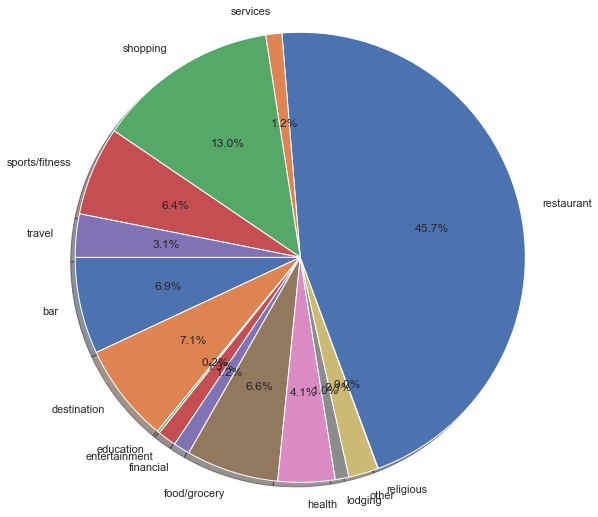

In [1713]:
#display summary totals on number of places by major category
import matplotlib.pyplot as plt
total_places = places_summary.sum(axis=0)
total_places.drop(['Neighborhood','Latitude','Longitude'], inplace=True)
total_places.index

# Data to plot
labels = total_places.index
sizes = total_places.values
#colors = range(total_places.index)
explode = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)  
ax1 = plt.subplots(figsize=(9, 9))
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')

plt.show()

### It is clear from review of this data that the number of restaurants are significantly higher in the metropolitan areas than other venues (or at least those are the ones tagged by the Foursquare users).

Median Age                     36.72
Median Household Income    64,133.30
Avg Household Size              2.59
Median House Value        450,729.47
% Asian                         0.11
% African American              0.27
% Hawaiian                      0.00
% American Indian               0.00
% Other                         0.09
% White                         0.50
dtype: float64


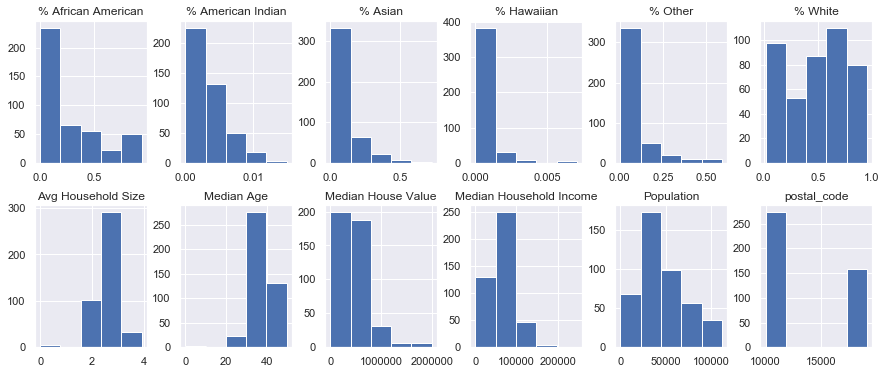

In [1714]:
#display overall averages for demographics
mean_demographics = demographics.mean(axis=0)
mean_demographics.drop(['postal_code','Population'], inplace=True)

print(mean_demographics)
demo_hist = demographics.hist(bins=5, layout=(2,6), figsize=(15,6))

### Demographic data appears to be within expected levels

### Prepare data for clustering model

In [1725]:
#Create new dataframe for Clustering model that combines neighborhoods, demographics & the places_summary dataframes
clustering_df = neighborhoods
clustering_df = pd.merge(clustering_df, demographics, on=['Neighborhood','postal_code'])
clustering_df.rename(columns={'latitude':'Latitude','longitude':'Longitude'}, inplace=True)
clustering_df = pd.merge(clustering_df, places_summary,on=['Neighborhood','Latitude','Longitude'])

#drop empty rows where Foursquare did not return venue data
clustering_df = clustering_df.dropna()

#save the dataframe to final_df to be used in the final reporting before dropping the columns not used in clustering
final_df = clustering_df

#drop all of the columns not used by the cluser model
clustering_df = clustering_df.drop(['Neighborhood','city','county','state','Latitude','Longitude','postal_code',
                                    'Population','Median House Value'],axis=1)

#normalize Median data in data frame before clustering
clustering_df['Median Household Income'] = clustering_df['Median Household Income'].div(clustering_df['Median Household Income'].max())
clustering_df['Median Age'] = clustering_df['Median Age'].div(clustering_df['Median Age'].max())
clustering_df['Avg Household Size'] = clustering_df['Avg Household Size'].div(clustering_df['Avg Household Size'].max())

cluster_cols = ['bar','destination','education','entertainment','financial','food/grocery','health','lodging',
                'other','religious','restaurant','services','shopping','sports/fitness','travel']
clustering_df[cluster_cols] = clustering_df[cluster_cols].div(100)

print(clustering_df.shape)
clustering_df.head()

(422, 24)


,Median Age,Median Household Income,Avg Household Size,% Asian,% African American,% Hawaiian,% American Indian,% Other,% White,bar,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
0,0.77,0.21,0.72,0.10,0.27,0.00,0.00,0.08,0.52,0.00,...,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.00
1,0.74,0.23,0.71,0.26,0.08,0.00,0.00,0.05,0.56,0.00,...,0.01,0.00,0.00,0.00,0.00,0.09,0.00,0.02,0.01,0.00
2,0.83,0.35,0.73,0.17,0.04,0.00,0.00,0.03,0.73,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00
3,0.77,0.69,0.53,0.16,0.02,0.00,0.00,0.01,0.78,0.00,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.05
4,0.66,0.21,1.00,0.12,0.11,0.00,0.01,0.37,0.38,0.01,...,0.05,0.03,0.00,0.00,0.00,0.28,0.00,0.02,0.02,0.02


## Start the Clustering Model 
The clustering model will run based on the demographic data (age, income, race, etc.) and also on the number of various places within walking distance of the neighborhood. 

### Start by selecting the appropriate number of clusters

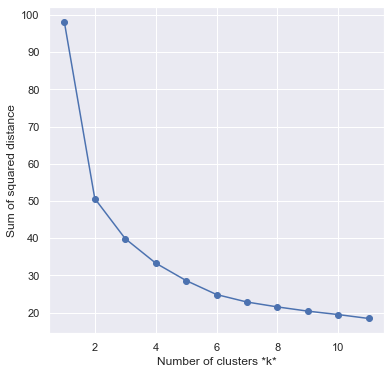

In [1726]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#test for the optimal number of clusters to use
sse = []
list_k = list(range(1, 12))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(clustering_df)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');                          

In [1727]:
# set number of clusters (looks to be optimal number of clusters from chart above)
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_df)

# check cluster labels generated for each row in the dataframe
print ('Cluster label count = {}'.format(len(kmeans.labels_)))
kmeans.labels_[0:20]

Cluster label count = 422


array([1, 5, 0, 0, 4, 1, 4, 3, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0],
      dtype=int32)

### Measure the accuracy of the model

In [1728]:
#Measure the inertia or accuracy of the clustering model. 
print ('{:,.1f}'.format(kmeans.inertia_))

24.9


## Add the Cluster lables to the dataframe for mapping

In [1729]:
#add clustering labels (previously set final_df = cluster_df)
final_df.insert(0, 'Cluster Labels', kmeans.labels_)

print(final_df.shape)
final_df.head()

(422, 34)


,Cluster Labels,Neighborhood,city,county,state,Latitude,Longitude,postal_code,Median Age,Median Household Income,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
0,1,Park Hill,New York,Richmond,NY,40.61,-74.08,10304,38.10,52199,...,1,0,0,0,0,1,0,1,1,0
1,5,Kew Gardens Hills,New York,Queens,NY,40.73,-73.82,11367,36.40,57933,...,1,0,0,0,0,9,0,2,1,0
2,0,Bloomfield,New York,Richmond,NY,40.62,-74.19,10314,40.80,86742,...,0,0,0,0,0,0,1,1,1,0
3,0,Ellis Island,New York,New York,NY,40.70,-74.04,10280,38.10,169844,...,0,0,0,1,0,1,0,0,0,5
4,4,Corona,New York,Queens,NY,40.75,-73.86,11368,32.40,50797,...,5,3,0,0,0,28,0,2,2,2


# Results Section <a name="results"></a>
***
## Summaries by Cluster

In [1730]:
pd.options.display.float_format = '{:,.2f}'.format
Cluster_Summary = final_df.drop(columns=['Latitude','Longitude','Population','postal_code'])
Cluster_Summary = Cluster_Summary.groupby('Cluster Labels').mean()
Cluster_Summary.sort_values(by=['Median Household Income'])


,Median Age,Median Household Income,Avg Household Size,Median House Value,% Asian,% African American,% Hawaiian,% American Indian,% Other,% White,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
4,32.85,"36,840.91",2.97,"307,152.83",0.05,0.37,0.00,0.01,0.32,0.21,...,2.17,0.92,0.06,0.40,0.00,8.58,0.21,2.36,1.11,0.74
2,36.17,"42,700.22",2.61,"241,804.35",0.03,0.79,0.00,0.00,0.03,0.12,...,1.10,0.59,0.06,0.23,0.00,5.93,0.23,2.30,0.74,1.04
1,34.00,"51,687.09",2.65,"342,859.46",0.08,0.32,0.00,0.00,0.08,0.48,...,1.14,0.77,0.11,0.42,0.00,8.12,0.27,2.30,1.15,0.72
5,40.01,"65,311.74",2.95,"615,405.88",0.38,0.07,0.00,0.00,0.12,0.40,...,2.50,1.44,0.00,0.24,0.00,13.47,0.24,2.35,1.09,0.71
0,39.93,"77,420.83",2.59,"451,759.26",0.09,0.07,0.00,0.00,0.04,0.77,...,0.96,0.53,0.07,0.30,0.01,5.87,0.29,2.33,1.32,0.74
3,36.47,"102,785.19",2.06,"911,228.07",0.16,0.08,0.00,0.00,0.05,0.67,...,3.88,3.04,1.32,1.98,0.02,38.11,0.49,9.56,4.81,0.63


## Map the Neighborhoods in each Cluster

In [1732]:
# create map
import folium
from colr import color

# Matplotlib and associated plotting modules|
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude = 39.5
longitude = -74.5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9, height=1500)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


print ('Cluster legend')
legend_str = 'Cluster : '
for clstr in final_df['Cluster Labels'].unique():
    legend_str = legend_str + color('{} ', fore=rainbow[clstr-1]).format(clstr)
print (legend_str)
map_clusters

Cluster legend
Cluster : 1 5 0 4 3 2 


# Discussion Section <a name="discussion"></a>
***

The results of the analysis shows a significant overlap in the types of most neighborhoods between Philadelphia and New York with similarities that should allow the user to leverage the model to narrow down the selection process when looking to relocate between the two cities. 

Below is a list of the clusters with some of the main differences highlighted.

Cluster 0 : **2nd highest Median Age, 2nd highest average household income**, below average household size, average house value, and **the least racially diverse cluster with 77% white**, below average number of locations within walking distance

Cluster 1 :	**2nd lowest Median age**, average income levels, household size, and home values, **racially diverse**, average number of places within walking distance

Cluster 2 :	Average age, **2nd lowest average income, average home size, low median home value, low racial diversity , heavily African American, lowest total number of locations within walking distance**

Cluster 3 :	Average age, **highest avg income, lowest household size, highest median home value, second least racially diverse but 16% Asian population, highest (4X others) average locations especially bars, restaurants, etc.**

Cluster 4 :	**Youngest Median Age, lowest household income, very diverse population, largest household size**, average  number of locations

Cluster 5 :	**Oldest Median age**, average household income, **high household size and home value, largest Asian population percentage but racially diverse**, second highest number of places within walking distance especially restaurants. **Especially of note in this cluster is that they are all NYC neighborhoods with no matching Philadelphia neighborhoods.** 

 



### Summary by Cluster and City

In [1797]:
format_cols = ['% Asian','% African American','% Hawaiian','% American Indian','% Other','% White']
CC_summary = Cluster_report_df.groupby(['Cluster Labels','city']).mean()

for col in format_cols : CC_summary[col] = CC_summary[col].map('{:.2%}'.format)
CC_summary = CC_summary.transpose()
CC_summary

Cluster Labels                   0                       1               \
city                      New York Philadelphia   New York Philadelphia   
Median Age                   41.39        37.35      37.06        30.58   
Median Household Income  84,431.70    65,116.04  58,270.59    44,351.20   
Avg Household Size            2.66         2.46       2.72         2.57   
Median House Value      573,039.53   238,900.00 486,679.49   182,602.86   
Population               48,821.09    33,907.57  53,576.33    43,240.03   
% Asian                      9.92%        7.89%      7.44%        8.86%   
% African American           5.06%       10.24%     29.92%       33.99%   
% Hawaiian                   0.05%        0.07%      0.04%        0.05%   
% American Indian            0.25%        0.23%      0.34%        0.45%   
% Other                      5.14%        2.79%     10.81%        5.49%   
% White                     76.95%       76.18%     47.61%       47.48%   
bar                           0.83         1.49       0.79         1.66   
destination                   1.45         1.59       1.23         1.71   
education                     0.02         0.02       0.05         0.06   
entertainment                 0.19         0.22       0.15         0.43   
financial                     0.37         0.10       0.28         0.20   
food/grocery                  1.02         0.86       1.18         1.09   
health                        0.49         0.59       0.85         0.69   
lodging                       0.08         0.06       0.03         0.20   
other                         0.33         0.24       0.41         0.43   
religious                     0.00         0.02       0.00         0.00   
restaurant                    6.22         5.27       7.67         8.63   
services                      0.31         0.24       0.36         0.17   
shopping                      1.83         3.22       2.21         2.40   
sports/fitness                1.16         1.59       1.13         1.17   
travel                        0.98         0.33       1.03         0.37   

Cluster Labels                   2                         3               \
city                      New York Philadelphia     New York Philadelphia   
Median Age                   38.07        35.08        37.11        33.43   
Median Household Income  57,971.84    34,023.16   110,266.21    67,624.40   
Avg Household Size            2.82         2.49         2.08         2.00   
Median House Value      466,368.00   114,211.36 1,028,508.51   360,010.00   
Population               55,156.52    37,568.98    42,352.45    27,817.20   
% Asian                      2.62%        2.91%       15.63%       16.90%   
% African American          77.04%       80.58%        7.18%       11.19%   
% Hawaiian                   0.05%        0.04%        0.08%        0.02%   
% American Indian            0.36%        0.31%        0.29%        0.35%   
% Other                      7.12%        1.11%        5.08%        1.80%   
% White                     10.45%       12.28%       67.69%       66.02%   
bar                           0.76         0.41         7.09         6.10   
destination                   0.76         1.41         4.83         3.20   
education                     0.00         0.02         0.09         0.00   
entertainment                 0.12         0.02         1.45         1.30   
financial                     0.44         0.05         0.34         0.10   
food/grocery                  1.96         0.61         4.11         2.80   
health                        0.80         0.48         3.26         2.00   
lodging                       0.04         0.07         1.26         1.60   
other                         0.52         0.07         2.13         1.30   
religious                     0.00         0.00         0.02         0.00   
restaurant                    8.96         4.20        38.87        34.50   
services                      0.40         0.14    

## Neighborhood List for each Cluster

## Cluster 0 neighborhoods

In [1805]:
#Create a list of neighborhoods for each Cluster
Cluster_report_df = final_df.drop(columns=['county','state','Latitude','Longitude','postal_code'])

print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 0])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 0 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 0 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 0]

Number of neighborhoods in Cluster = 135
Number of NYC neighborhoods in Cluster = 86
Number of Philly neighborhoods in Cluster = 49


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
2,0,Bloomfield,New York,40.80,86742,2.85,485300,90761,0.17,0.04,...,0,0,0,0,0,0,1,1,1,0
3,0,Ellis Island,New York,38.10,169844,2.06,910500,9384,0.16,0.02,...,0,0,0,1,0,1,0,0,0,5
8,0,Prince's Bay,New York,40.50,103175,2.91,570200,33531,0.04,0.01,...,0,1,0,0,0,6,0,2,0,0
10,0,Annadale,New York,41.60,95064,2.88,518000,61741,0.05,0.01,...,0,0,0,0,0,0,0,0,2,0
11,0,Howard Beach,New York,45.00,71648,2.73,504300,29219,0.05,0.02,...,0,2,0,0,0,12,2,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0,Germany Hill,Philadelphia,34.70,72563,2.37,244000,38309,0.03,0.13,...,0,0,0,0,0,1,0,1,2,0
416,0,Byberry,Philadelphia,39.10,65082,2.73,197900,34253,0.04,0.09,...,0,0,0,0,0,0,0,0,2,0
418,0,Franklin Mills,Philadelphia,39.10,65082,2.73,197900,34253,0.04,0.09,...,2,0,0,0,0,7,0,38,1,0
419,0,Torresdale,Philadelphia,40.90,56781,2.41,189700,31736,0.04,0.10,...,1,0,0,0,0,3,2,2,2,0


## Cluster 1 neighborhoods

In [1804]:
print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 1])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 1 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 1 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 1]

Number of neighborhoods in Cluster = 74
Number of NYC neighborhoods in Cluster = 39
Number of Philly neighborhoods in Cluster = 35


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
0,1,Park Hill,New York,38.10,52199,2.82,471400,41064,0.10,0.27,...,1,0,0,0,0,1,0,1,1,0
5,1,Marble Hill,New York,39.80,58551,2.40,287400,71360,0.04,0.15,...,2,2,0,0,0,9,0,3,3,0
9,1,Floyd Bennett Field,New York,40.30,81399,3.00,556500,95666,0.07,0.46,...,0,0,0,0,0,0,0,0,0,0
25,1,Flatlands,New York,40.30,81399,3.00,556500,95666,0.07,0.46,...,2,2,0,0,0,2,0,6,0,0
27,1,Randall Manor,New York,38.20,55802,2.52,454600,38733,0.06,0.25,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,1,Packer Park,Philadelphia,37.60,42009,2.54,178100,46623,0.14,0.31,...,0,0,0,0,0,1,0,0,2,0
400,1,Belmont,Philadelphia,22.80,25865,2.42,123800,54311,0.14,0.42,...,0,0,0,0,0,3,0,0,0,1
401,1,Burnholme,Philadelphia,41.70,94551,2.88,234700,6702,0.10,0.32,...,1,3,0,0,0,6,0,4,0,1
417,1,West Passyunk,Philadelphia,37.60,42009,2.54,178100,46623,0.14,0.31,...,0,0,0,0,0,7,0,1,0,0


## Cluster 2 neighborhoods

In [1806]:
print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 2])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 2 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 2 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 2]

Number of neighborhoods in Cluster = 69
Number of NYC neighborhoods in Cluster = 25
Number of Philly neighborhoods in Cluster = 44


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
26,2,Queens Village,New York,39.00,83240,3.72,434500,27403,0.04,0.76,...,0,2,0,1,0,2,0,1,0,0
32,2,Harlem,New York,36.10,37232,2.30,606500,29882,0.02,0.63,...,2,2,0,1,0,20,0,5,3,0
68,2,Rochdale,New York,37.90,62207,2.96,402400,65791,0.02,0.88,...,4,1,0,0,0,6,1,1,0,2
73,2,Jamaica,New York,35.00,51521,3.46,411500,36489,0.09,0.64,...,2,0,0,0,0,5,0,0,0,1
81,2,Wingate,New York,39.80,51277,2.66,447400,75451,0.02,0.89,...,2,0,0,0,0,5,1,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2,Mount Airy West,Philadelphia,43.20,61297,2.39,257400,29391,0.02,0.59,...,1,1,0,1,0,1,0,2,1,0
412,2,East Oak Lane,Philadelphia,39.30,41266,2.61,153900,15863,0.04,0.83,...,0,0,0,0,0,2,0,0,0,0
420,2,Wissahickon Park,Philadelphia,43.20,61297,2.39,257400,29391,0.02,0.59,...,0,0,0,0,0,0,0,0,1,0
423,2,Haddington,Philadelphia,33.30,28505,2.63,79100,44870,0.03,0.89,...,2,0,0,0,0,6,0,3,1,2


## Cluster 3 neighborhoods

In [1807]:
print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 3])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 3 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 3 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 3]

Number of neighborhoods in Cluster = 57
Number of NYC neighborhoods in Cluster = 47
Number of Philly neighborhoods in Cluster = 10


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
7,3,Greenwich Village,New York,40.60,128613,1.68,964200,50472,0.09,0.06,...,3,5,1,2,0,61,0,11,5,0
22,3,Chelsea,New York,40.60,128613,1.68,964200,50472,0.09,0.06,...,2,2,1,4,0,29,0,5,5,0
23,3,Sheepshead Bay,New York,36.00,246813,2.25,2000000,7023,0.12,0.05,...,2,6,6,5,0,42,1,15,7,0
28,3,Park Slope,New York,36.00,123583,2.43,1138500,70156,0.08,0.05,...,3,5,0,3,0,49,0,18,2,0
29,3,Turtle Bay,New York,39.70,127506,1.57,637300,15801,0.21,0.02,...,6,4,5,3,0,55,0,5,5,2
31,3,Greenpoint,New York,34.80,85111,2.10,818200,36492,0.05,0.04,...,7,4,1,3,0,27,3,10,1,1
33,3,Vinegar Hill,New York,35.20,124996,2.06,915900,62823,0.12,0.14,...,1,2,0,3,0,12,0,5,1,0
41,3,Washington Heights,New York,35.80,58614,2.99,495800,59607,0.02,0.10,...,10,1,0,5,0,47,2,18,4,2
42,3,Carroll Gardens,New York,35.90,100213,2.41,1268600,37845,0.06,0.14,...,6,6,0,1,1,43,1,14,2,0
43,3,Financial District,New York,30.10,173333,2.02,1415400,8831,0.17,0.03,...,1,6,2,5,0,49,0,9,8,4


## Cluster 4 neighborhoods

In [1808]:
print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 4])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 4 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 4 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 4]

Number of neighborhoods in Cluster = 53
Number of NYC neighborhoods in Cluster = 36
Number of Philly neighborhoods in Cluster = 17


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
4,4,Corona,New York,32.40,50797,3.92,532800,112425,0.12,0.11,...,5,3,0,0,0,28,0,2,2,2
6,4,Belmont,New York,29.00,33932,2.96,383400,83960,0.03,0.20,...,10,0,1,0,0,38,2,7,1,4
14,4,Williamsbridge,New York,40.20,63652,3.18,438900,73870,0.07,0.54,...,1,1,0,0,0,6,0,0,0,0
18,4,Hamilton Heights,New York,34.20,49891,2.72,417000,60254,0.04,0.30,...,1,3,0,4,0,34,1,2,0,0
54,4,Morris Heights,New York,30.40,25275,2.86,427200,79606,0.01,0.32,...,1,1,0,0,0,3,0,0,1,2
59,4,Port Morris,New York,29.60,21149,2.83,430200,38203,0.00,0.32,...,2,1,0,1,0,7,0,2,0,1
61,4,Longwood,New York,31.30,27687,2.90,389400,48351,0.01,0.34,...,4,4,0,0,0,17,0,8,2,2
67,4,Holliswood,New York,40.80,70266,3.16,475000,31400,0.29,0.39,...,1,1,0,0,0,0,0,1,1,0
70,4,Bronx Park,New York,33.70,37015,2.78,335400,103732,0.06,0.35,...,0,0,0,2,0,2,0,6,1,0
72,4,Concourse,New York,30.90,27106,2.98,345200,94218,0.01,0.43,...,3,1,0,0,0,11,0,1,0,0


## Cluster 5 neighborhoods

In [1809]:
print('Number of neighborhoods in Cluster = {}'.format(len(Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 5])))
print('Number of NYC neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 5 and city == "New York"'))))
print('Number of Philly neighborhoods in Cluster = {}'.format(len(Cluster_report_df.query('`Cluster Labels` == 5 and city == "Philadelphia"'))))
Cluster_report_df.loc[Cluster_report_df['Cluster Labels'] == 5]

Number of neighborhoods in Cluster = 34
Number of NYC neighborhoods in Cluster = 34
Number of Philly neighborhoods in Cluster = 0


,Cluster Labels,Neighborhood,city,Median Age,Median Household Income,Avg Household Size,Median House Value,Population,% Asian,% African American,...,food/grocery,health,lodging,other,religious,restaurant,services,shopping,sports/fitness,travel
1,5,Kew Gardens Hills,New York,36.40,57933,2.80,479700,41824,0.26,0.08,...,1,0,0,0,0,9,0,2,1,0
24,5,Douglaston-Little Neck,New York,49.40,89185,2.58,521500,18721,0.43,0.01,...,2,1,0,0,0,4,1,1,0,0
30,5,Rego Park,New York,43.80,63161,2.19,361400,42653,0.32,0.04,...,7,3,0,0,0,16,0,4,2,0
35,5,Glen Oaks,New York,44.40,92657,2.77,523700,15234,0.43,0.07,...,2,0,0,0,0,1,0,0,0,0
38,5,Oakland Gardens,New York,44.80,76988,2.71,538900,36806,0.52,0.03,...,1,2,0,0,0,3,0,1,1,1
44,5,Richmond Hill,New York,35.10,66570,3.48,522500,38517,0.24,0.07,...,1,0,0,0,0,7,0,0,0,1
50,5,Sunset Park,New York,34.30,47079,3.39,827800,95643,0.41,0.03,...,3,2,0,0,0,16,0,4,2,0
51,5,Astoria Heights,New York,37.50,65098,3.17,671400,32514,0.22,0.15,...,1,0,0,0,0,3,2,2,3,1
58,5,Murray Hill,New York,45.50,42500,2.65,498400,55200,0.63,0.03,...,3,0,0,0,0,23,1,3,0,0
76,5,Jamaica Hills,New York,36.00,55906,3.10,583900,62053,0.42,0.16,...,2,2,0,0,0,5,0,0,1,0


# Conclusion Section <a name="conclusion"></a>

The purpose of this analysis was to build a model that could recommend neighborhoods for relocation to people in NYC looking to relocate to Philadelphia and commute to NYC. The premise of the model would be to find similar neighborhoods within the 2 cities based on demographic data and places of interest. This recommendation engine would allow the users to find neighborhoods in the Philadelphia area that were similar in makeup to those that they were familiar with in New York and help to speed the research process. 

The model shows that it is possible to create a model based on these parameters. Similar features were found in online models by real estate agents but not ones where the customer could select a neighborhood in their city that they were familiar with and then have the system provide similar neighborhoods in other cities. 

This model could be refined further to allow the customer to weight the importance of the factors making the model more flexible and make the decision and research process simpler for the end users. 
***